In [1]:
import numpy as np
from mesa import Model
from mesa import Agent
from mesa.space import SingleGrid
from mesa.time import SimultaneousActivation
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import time
import matplotlib.pyplot as plt

In [ ]:
# Dealing with error
!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

### Method 1: Agents are Trees, Simultaneous Activation

In [3]:
class Forest_Trees(Model):
    
    def __init__(self, width=50, height=50, density = 0.57):
        
        self.width = width
        self.height = height
        self.density = density
        
        self.grid = SingleGrid(width, height, torus=False)
        self.schedule = SimultaneousActivation(self)
        self.running = True
        
        for _, x, y in self.grid.coord_iter():
            if np.random.uniform() < self.density:
                tree = Tree((x, y), self)
                self.grid.place_agent(tree, (x, y))
                self.schedule.add(tree)
        
        self.statuses = {'Green':0, 'Burning':0, 'Embers':0}
    
    def step(self):
        self.statuses = {'Green':0, 'Burning':0, 'Embers':0}
        self.schedule.step()
        
        if self.statuses['Burning'] == 0:
            self.running = False
            
class Tree(Agent):
    
    def __init__(self, pos, model):
        super().__init__(pos, model)
        self.status = "Green"
        self.next = "Green"
        
        #print("Hi! I'm a tree at position ({}, {})".format(self.pos[0], self.pos[1]))
    
    def step(self):
        if self.model.schedule.time == 0:
            self.neighbors = self.model.grid.iter_neighbors(self.pos, moore=False)

        if self.pos[0] == 0:
            self.next = "Burning"
            
        if self.status == "Burning":
            for neighbor in self.neighbors:
                if neighbor.status == "Green":
                    neighbor.next = "Burning"
            self.next = "Embers"
            
    def advance(self):
        self.status = self.next
        self.model.statuses[self.status] += 1

Time to make this plot: 1.744246482849121


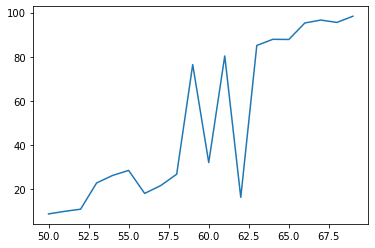

In [4]:
t0 = time.time()
pct_burnt_by_density = {}
for i in range(50, 70):
    ff = Forest_Trees(density= i / 100)
    while ff.running:
        ff.step()
    
    pct_burnt_by_density[i] = 100 * ff.statuses['Embers'] / sum(ff.statuses.values())

plt.plot(pct_burnt_by_density.keys(), pct_burnt_by_density.values());
print("Time to make this plot:", time.time() - t0)

### Method 2: Agents are Flames, Random Activation

In [6]:
class Forest_Fire(Model):
    
    def __init__(self, height=125, width=125, density=0.57):
        
        self.height = height
        self.width = width
        self.density = density
    
        self.trees = np.random.choice([True, False], 
                                      size=(self.width, self.height), 
                                      p=[self.density, 1-self.density])
        
        self.tree_count = np.sum(self.trees)
        
        self.burning = 0
        
        self.grid = SingleGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        self.running = True
        
        #print("Time 0")
        for _, x, y in self.grid.coord_iter():
            if x == 0 and self.trees[x, y]:
                self.ignite((x, y))
        
        self.pct_burnt = 100 * self.schedule.get_agent_count() / self.tree_count
        
        self.datacollector = DataCollector({
            "Percent_Burnt": lambda m: m.pct_burnt
        })
        self.datacollector.collect(self)
    
    def ignite(self, pos):
        fire = Fire(self)
        self.grid.place_agent(fire, pos)
        self.schedule.add(fire)
    
    def step(self):
        self.burning = 0

        self.schedule.step()
        
        self.pct_burnt = 100 * self.schedule.get_agent_count() / self.tree_count
        self.datacollector.collect(self)
        
        if self.burning == 0:
            self.running = False
            #print(self.pct_burnt)

                
class Fire(Agent):
    
    def __init__(self, model):
        super().__init__(self, model)
        self.status = "On Fire"
        
    def step(self):
        if self.status == "On Fire":
            for x, y in self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False):
                if self.model.trees[x, y] and self.model.grid.is_cell_empty((x, y)):
                    self.model.ignite((x, y))
                    self.model.burning += 1
                        
            self.status = "Embers"

Time to make this plot: 0.9782354831695557


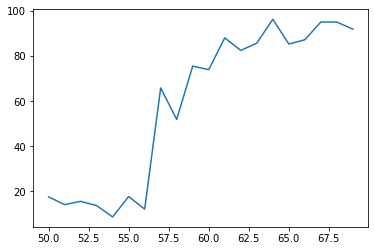

In [7]:
t0 = time.time()
pct_burnt_by_density = {}
for i in range(50, 70):
    ff = Forest_Fire(50, 50, i / 100)
    while ff.running:
        ff.step()
    
    pct_burnt_by_density[i] = ff.pct_burnt
    
plt.plot(pct_burnt_by_density.keys(), pct_burnt_by_density.values());
print("Time to make this plot:", time.time() - t0)

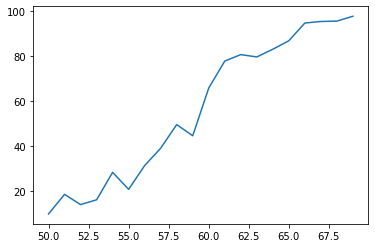

In [9]:
# Smoother plot

pct_burnt_by_density = {}
for i in range(50, 70):
    results = []
    for j in range(10):
        ff = Forest_Fire(50, 50, i / 100)
        while ff.running:
            ff.step()
        results.append(ff.pct_burnt)
    
    pct_burnt_by_density[i] = results
    
plt.plot(pct_burnt_by_density.keys(), [sum(results)/len(results) for results in pct_burnt_by_density.values()]);

### Visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation

from IPython.display import HTML

In [ ]:
ani = animate(Forest())
HTML(ani.to_jshtml())

In [ ]:
def animate(model):

    cmap = colors.ListedColormap(['red', 'brown', 'green', 'black'])
    formatter = plt.FuncFormatter(lambda val, loc: ['On Fire', 'Embers', 'Green', 'Empty'][loc])
    
    fig, ax = plt.subplots()
    img = ax.imshow(render(Forest()), cmap=cmap)
    fig.colorbar(img, ticks=[0,1,2,3], format=formatter, ax=ax)

    ax.axis('off')

    plt.close()

    ani = animation.FuncAnimation(fig,
                                  update,
                                  fargs=(img, Forest(),),
                                  frames=100,
                                  interval=500,
                                  save_count=500)
    return ani

In [ ]:
def update(frameNum, img, model):
    model.step()
    img.set_data(render(model))
    return img

In [ ]:
def render(model):
    agent_types = np.zeros((model.grid.width, model.grid.height))
    for content, x, y in model.grid.coord_iter():
        if content:
            cell_content = ["On Fire", "Embers"].index(content.status)
        elif model.trees[x, y]:
            cell_content = 2
        else:
            cell_content = 3
            
        agent_types[x][y] = cell_content
    
    return agent_types